[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Denis-R-V/TSR/blob/main/main.ipynb)

# Система распознавания дорожных знаков на датасете RTSD

## Анализ датасета GTSRB
https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

Датасет содержит 3 каталога и 3 файла аннотации:
- Meta;
- Train;
- Test;
- Meta.csv;
- Train.csv;
- Test.csv;

In [9]:
colab = False

if colab == True:
    from google.colab import drive
    drive.mount('/content/drive')
    !pip install kaggle
    !mkdir ~/.kaggle
    !cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
    !kaggle datasets download watchman/rtsd-dataset
    !unzip rtsd-dataset.zip
    !rm rtsd-dataset.zip
    !cp -r rtsd-frames/rtsd-frames/ .
    !rm -r rtsd-frames/rtsd-frames/
    !pip install fiftyone

if colab == True:
    dataset_path = '.'
    checkpoints_path = '../content/drive/MyDrive/TSR/checkpoints'
else:
    dataset_path = 'data'
    checkpoints_path = 'checkpoints'


In [10]:
import os
import json
import numpy as np 
import pandas as pd 

from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
#import matplotlib.patches as patches

#from pycocotools.coco import COCO
#import fiftyone as fo
import time
import torch
import torch.nn as nn
#import torchvision
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import resnet152
from sklearn import metrics
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
#from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
#from torchvision.models.detection import FasterRCNN

#import cv2

### Meta.csv

In [11]:
Meta = pd.read_csv(os.path.join(dataset_path, 'GTSRB', 'Meta.csv'))
Meta

,Path,ClassId,ShapeId,ColorId,SignId
0,Meta/27.png,27,0,0,1.32
1,Meta/0.png,0,1,0,3.29
2,Meta/1.png,1,1,0,3.29
3,Meta/10.png,10,1,0,3.27
4,Meta/11.png,11,0,0,1.22
5,Meta/12.png,12,2,2,2.3
6,Meta/13.png,13,4,0,2.1
7,Meta/14.png,14,3,0,2.2
8,Meta/15.png,15,1,0,3.1
9,Meta/16.png,16,1,0,3.3


In [1]:
image_id = 2
Image.open(os.path.join(dataset_path, 'GTSRB', f'Meta/{image_id}.png'))

NameError: name 'Image' is not defined

Расшифровка знаков
- 0 - Ограничение скорости (20)                                 3_24
- 1 - Ограничение скорости (30)                                 3_24                             
- 2 - Ограничение скорости (50)                                 3_24
- 3 - Ограничение скорости (60)                                 3_24
- 4 - Ограничение скорости (70)                                 3_24
- 5 - Ограничение скорости (80)                                 3_24
- 6 - Конец ограничения скорости (80)                           3_25
- 7 - Ограничение скорости (100)                                3_24
- 8 - Ограничение скорости (120)                                3_24
- 9 - Обгон запрещен                                            3_20
- 10 - Обгон для грузовых автомобилей более 3,5т запрещен
- 11 - Пересечение со второстепенной дорогой (немного не похож) 2_3
- 12 - Главная дорога                                           2_1
- 13 - Уступи дорогу                                            2_4
- 14 - Стоп                                                     2_5
- 15 - Движение запрещено                                       3_2
- 16 - Автомобилям весом более 3,5т проезд запрещен             3_4_1
- 17 - Въезд запрещен (кирпич)                                  3_1
- 18 - Опасность на дороге (восклицательный знак)               1_33
- 19 - Опасный поворот (налево)                                 1_11_1
- 20 - Опасный поворот (направо)                                1_11
- 21 - Опасные повороты (в российском влево и вправо отличаются)
- 22 - Неровная дорога (желтая)                                 1_16
- 23 - Опасность заноса или скольжения                          1_15
- 24 - Сужение дороги (в российском слева и справа отличаются)  
- 25 - Дорожные работы                                          1_25
- 26 - Светофор                                                 1_8
- 27 - Осторожно пешеходы                                       1_22
- 28 - Осторожно дети (немного отличается)                      1_23   
- 29 - Осторожно велосипедисты (в российских нет)
- 30 - Скольжение из-за снега или льда (в российских нет)
- 31 - Дикие животные                                           1_27              
- 32 - Конец всех ограничений                                   3_31
- 33 - Движение направо                                         4_1_2
- 34 - Движение налево                                          4_1_3
- 35 - Движение прямо                                           4_1_1
- 36 - Прямо или направо                                        4_1_4
- 37 - Прямо или налево                                         4_1_5
- 38 - Объезд справа                                            4_2_1  
- 39 - Объезд слева                                             4_2_2
- 40 - Круговое движение                                        4_3
- 41 - Конец зоны запрещения обгона                             3_21
- 42 - конец зоны запрещения обгона авто более 3,5т

### Train.csv

In [6]:
Train = pd.read_csv(os.path.join(dataset_path, 'GTSRB', 'Train.csv'))
Train

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png
...,...,...,...,...,...,...,...,...
39204,52,56,5,6,47,51,42,Train/42/00042_00007_00025.png
39205,56,58,5,5,51,53,42,Train/42/00042_00007_00026.png
39206,58,62,5,6,53,57,42,Train/42/00042_00007_00027.png
39207,63,69,5,7,58,63,42,Train/42/00042_00007_00028.png


Распределение частот появления классов в обучающей выборке

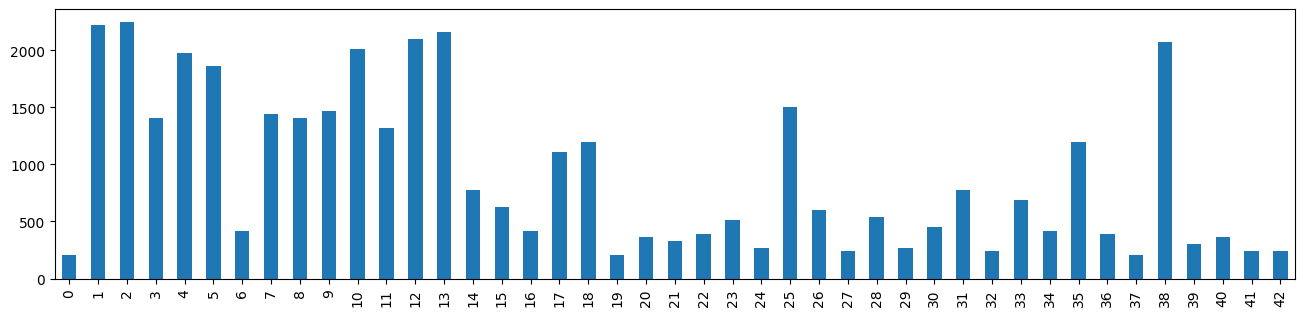

In [7]:
Train_counts = pd.Series(data = Train.value_counts(['ClassId']).sort_index())
Train_counts.index = range(43)
fig, ax = plt.subplots(nrows=1,ncols=1)
ax = Train_counts.plot(kind='bar')
fig.set_size_inches(16,3.5)
plt.show()

In [434]:
index = 0

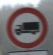

In [435]:
class_id = 16
#index = 0
df_temp = Train[Train['ClassId'] == class_id].copy()
df_temp.reset_index(inplace=True)
img_name = df_temp.loc[index, 'Path']
index+=1
Image.open(os.path.join(dataset_path, 'GTSRB', img_name))


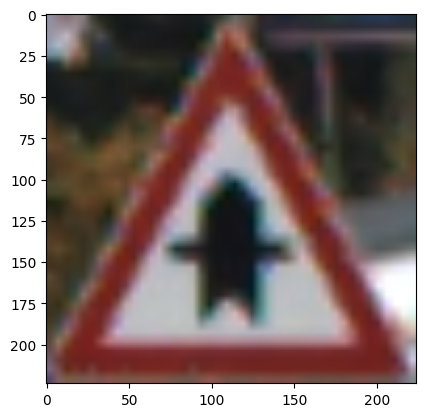

In [609]:
image_id = 17084
x1 = Train.loc[image_id, 'Roi.X1']
y1 = Train.loc[image_id, 'Roi.Y1']
x2 = Train.loc[image_id, 'Roi.X2']
y2 = Train.loc[image_id, 'Roi.Y2']
bbox = [x1, y1, x2, y2]
img = Image.open(os.path.join(dataset_path, 'GTSRB', Train.loc[image_id, 'Path'])).crop(bbox)
transform = transforms.Compose([transforms.Resize((224,224)),
                                    transforms.ToTensor()
                                    ])   
img = transform(img)
img = img.permute(1, 2, 0).detach().numpy()
img = img*255
img = img.astype(np.uint8)
fig, a = plt.subplots(1,1)
i += 1
a.imshow(img)

### Test.csv

In [38]:
Test = pd.read_csv(os.path.join(dataset_path, 'GTSRB', 'Test.csv'))
Test

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png
...,...,...,...,...,...,...,...,...
12625,42,41,5,6,37,36,12,Test/12625.png
12626,50,51,6,5,45,46,33,Test/12626.png
12627,29,29,6,6,24,24,6,Test/12627.png
12628,48,49,5,6,43,44,7,Test/12628.png


Распределение частот появления классов в тестовой выборке

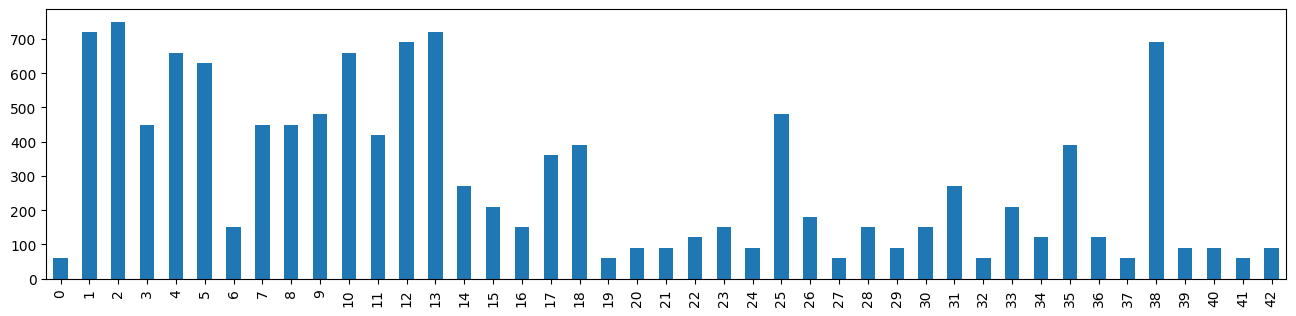

In [39]:
# Увеличим расстояние между графиками
Test_counts = pd.Series(data = Test.value_counts(['ClassId']).sort_index())
Test_counts.index = range(43)
fig, ax = plt.subplots(nrows=1,ncols=1)
ax = Test_counts.plot(kind='bar')
fig.set_size_inches(16,3.5)
plt.show()

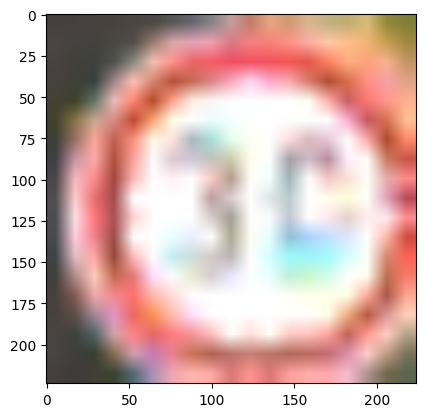

In [40]:
image_id = 122
x1 = Test.loc[image_id, 'Roi.X1']
y1 = Test.loc[image_id, 'Roi.Y1']
x2 = Test.loc[image_id, 'Roi.X2']
y2 = Test.loc[image_id, 'Roi.Y2']
bbox = [x1, y1, x2, y2]
img = Image.open(os.path.join(dataset_path, 'GTSRB', Test.loc[image_id, 'Path'])).crop(bbox)
transform = A.Compose([A.augmentations.geometric.resize.Resize (224, 224, interpolation=1, always_apply=False, p=1),
                              ToTensorV2(p=1.0)
                            ])
img = np.array(img).astype(np.float32)/255.
img = transform(image=img)['image']

img = img.permute(1, 2, 0).detach().numpy()
img = img*255
img = img.astype(np.uint8)
fig, a = plt.subplots(1,1)
a.imshow(img)

### Обучение классификатора на датасете GTSRB (без аугментации)

Загрузчик данных

In [42]:
class GTSRB_dataset_classifier(Dataset):
    def __init__(self, dataset_path, anno, transforms, crop = False):
        
        self.dataset_path = dataset_path
        self.transforms = transforms
        self.df_dataset = pd.read_csv(os.path.join(dataset_path, 'GTSRB', anno))
        self.crop = crop

    def __len__(self):
        return self.df_dataset.shape[0]

    def __getitem__(self, index):
        img_name = self.df_dataset.loc[index,'Path']
        img = Image.open(os.path.join(self.dataset_path, 'GTSRB', img_name))

        if self.crop == True:
            x1 = self.df_dataset.loc[index, 'Roi.X1']
            y1 = self.df_dataset.loc[index, 'Roi.Y1']
            x2 = self.df_dataset.loc[index, 'Roi.X2']
            y2 = self.df_dataset.loc[index, 'Roi.Y2']
            bbox = [x1, y1, x2, y2]
            img = img.crop(bbox)
        img = self.transforms(img)

        label = torch.tensor(self.df_dataset.loc[index,'ClassId'])
        
        return {'images':img, 'labels':label}

def get_transform(): 
    return transforms.Compose([transforms.Resize((224,224)),
                               transforms.ToTensor(),
                               ])   

In [43]:
test = GTSRB_dataset_classifier(dataset_path,
                                anno = 'Train.csv',
                                transforms = get_transform(),
                                crop = True)
test.__getitem__(2)['images'].shape

torch.Size([3, 224, 224])

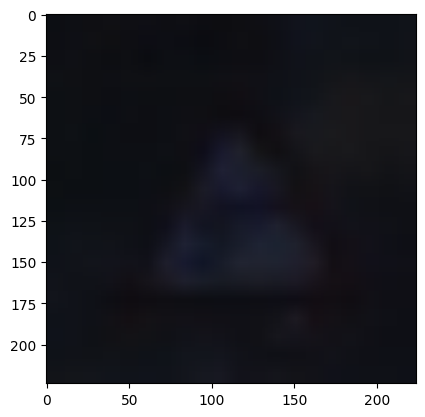

In [44]:
image_id = 122
img = test.__getitem__(image_id)['images']
img = img.permute(1, 2, 0).detach().numpy()
img = img*255
img = img.astype(np.uint8)
fig, a = plt.subplots(1,1)
a.imshow(img)

Гиперпараметры

In [14]:
device_id = 0
if torch.cuda.is_available() == True:
    device = f'cuda:{device_id}'
elif torch.backends.mps.is_available() == True:
    device = 'mps'
else:
    device = 'cpu'

model_name = 'GTSRB_resnet152_adam_001'
last_epoch = None
n_epochs = 10
batch_size = 32
num_classes = 43

device

'cuda:0'

Инициализация модели, задание оптимизатора и функции потерь

In [15]:
def create_model(num_classes):
    model = resnet152(weights='ResNet152_Weights.IMAGENET1K_V2')
    for param in model.parameters():
        param.requires_grad = False 
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    for param in model.fc.parameters():
        param.requires_grad = True
    return model

In [27]:
model = create_model(num_classes).to(device)

loss_function = nn.CrossEntropyLoss()

# parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

# Загрузка весов модели, состояния оптимизатора и шедулера
if last_epoch is not None:
    checkpoint = torch.load(os.path.join(checkpoints_path, f'chkpt_classifier_{model_name}_{last_epoch}.pth'), map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    #lr_scheduler.load_state_dict(checkpoint['lr_scheduler_state_dict'])

train_dataset = GTSRB_dataset_classifier(dataset_path,
                                         anno = 'Train.csv',
                                         transforms = get_transform(),
                                         crop = False)

val_dataset = GTSRB_dataset_classifier(dataset_path,
                                       anno = 'Test.csv',
                                       transforms = get_transform(),
                                       crop = False)

train_data_loader = DataLoader(train_dataset,
                               batch_size=batch_size,
                               shuffle=True,
                               )

val_data_loader = DataLoader(val_dataset,
                             batch_size=batch_size,
                             shuffle=False
                             )

In [25]:
def train(train_dataloader, epoch): 
    len_dataloader = len(train_dataloader)

    training_loss=0
    # для текущего accuracy
    correct = 0.0
    total = 0.0
    # для вывода метрик
    y_true = []
    y_pred = []

    model.train()
    running_loss = 0        # training_loss
    
    for batch_idx, data in enumerate(train_dataloader):
        
        optimizer.zero_grad()
        images = data['images'].to(device)
        targets = data['labels'].to(device)
        output = model(images)
        loss = loss_function(output, targets)
        loss.backward()
        optimizer.step()
       
        running_loss = running_loss + ((1/(batch_idx+1))*(loss.data-running_loss))
        if batch_idx%20 == 0:
            print(f"Batch Id {batch_idx} is having training loss of {running_loss}")
            print(loss.item())

        pred = output.data.max(1,keepdim=True)[1]

        # для текущего accuracy
        correct += np.sum(np.squeeze(pred.eq(targets.data.view_as(pred))).cpu().numpy())
        total += images.size(0)
        print(f"Epoch #{epoch}. Accuracy on batch {batch_idx}/{len_dataloader} on Training is {(100*correct/total)}")
        
        # для вывода метрик
        y_true.extend([int(item) for item in targets])
        y_pred.extend([int(item) for item in pred])

    train_loss = running_loss/len(train_dataloader.dataset)
    train_accuracy = metrics.accuracy_score(y_true, y_pred)
    train_f1_micro = metrics.f1_score(y_true, y_pred, average="micro")
    train_f1_macro =  metrics.f1_score(y_true, y_pred, average="macro")
    train_f1_weighted = metrics.f1_score(y_true, y_pred, average="weighted")
    return train_loss, train_accuracy, train_f1_micro, train_f1_macro, train_f1_weighted

In [26]:
def val (val_dataloader, epoch):
    len_dataloader = len(val_dataloader)

    validation_loss=0
    # для текущего accuracy
    correct = 0.0
    total = 0.0
    # для вывода метрик
    y_true = []
    y_pred = []

    model.eval()

    for batch_idx, data in enumerate(val_dataloader):
        
        
        optimizer.zero_grad()
        images = data['images'].to(device)
        targets = data['labels'].to(device)
        #with torch.no_grad():
            
        output = model(images)
        loss = loss_function(output, targets)
        
        validation_loss = validation_loss + ((1/(batch_idx+1))*(loss.data-validation_loss))
        #if batch_idx%20 == 0:
        print(f"Epoch #{epoch}. Batch Id {batch_idx} is having validation loss of {validation_loss}")
        print(loss.item())
        pred = output.data.max(1,keepdim=True)[1]

        # для текущего accuracy
        correct += np.sum(np.squeeze(pred.eq(targets.data.view_as(pred))).cpu().numpy())
        total += images.size(0)
        print(f"Epoch #{epoch}. Batch Id {batch_idx}/{len_dataloader} is having validation accuracy of {(100*correct/total)}")

        # для вывода метрик
        y_true.extend([int(item) for item in targets])
        y_pred.extend([int(item) for item in pred])

    val_loss = validation_loss/len(val_dataloader.dataset)
    val_accuracy = metrics.accuracy_score(y_true, y_pred)
    val_f1_micro = metrics.f1_score(y_true, y_pred, average="micro")
    val_f1_macro =  metrics.f1_score(y_true, y_pred, average="macro")
    val_f1_weighted = metrics.f1_score(y_true, y_pred, average="weighted")


    return val_loss, val_accuracy, val_f1_micro, val_f1_macro, val_f1_weighted

In [28]:
# Загрузка словарей с лоссами
if last_epoch is not None:
    train_losses = checkpoint['losses_train']
    val_losses = checkpoint['losses_val']
    train_accuracies = checkpoint['accuracies_train']
    val_accuracies = checkpoint['accuracies_val']
    train_f1_micros = checkpoint['train_f1_micro']
    val_f1_micros = checkpoint['val_f1_micro']
    train_f1_macros = checkpoint['train_f1_macro']
    val_f1_macros = checkpoint['val_f1_macro']
    train_f1_weighteds = checkpoint['train_f1_weighted']
    val_f1_weighteds = checkpoint['val_f1_weighted']
else:
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    train_f1_micros = []
    val_f1_micros = []
    train_f1_macros = []
    val_f1_macros = []
    train_f1_weighteds = []
    val_f1_weighteds = []

if last_epoch is None:
    start_epoch = 0
else:
    start_epoch = last_epoch +1

try:
    for epoch in range(start_epoch, n_epochs):
        start = time.time()
        train_loss, train_accuracy, train_f1_micro, train_f1_macro, train_f1_weighted = train(train_data_loader, epoch)
        val_loss, val_accuracy, val_f1_micro, val_f1_macro, val_f1_weighted = val(val_data_loader, epoch)
        #lr_scheduler.step()
        print(f"Эпоха #{epoch} train_loss: {train_loss}, val_loss: {val_loss}")  
        end = time.time()
        print(f"Потрачено {round((end - start) / 60, 1)} минут на {epoch} эпоху")
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        train_f1_micros.append(train_f1_micro)
        val_f1_micros.append(val_f1_micro)
        train_f1_macros.append(train_f1_macro)
        val_f1_macros.append(val_f1_macro)
        train_f1_weighteds.append(train_f1_weighted)
        val_f1_weighteds.append(val_f1_weighted)
        

        torch.save({'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    #'lr_scheduler_state_dict': lr_scheduler.state_dict(),
                    'losses_train': train_losses,
                    'losses_val': val_losses,
                    'accuracies_train': train_accuracies,
                    'accuracies_val': val_accuracies,
                    'f1_micros_train': train_f1_micros,
                    'f1_micros_val': val_f1_micros,
                    'f1_macros_train': train_f1_macros,
                    'f1_macros_val': val_f1_macros,
                    'f1_weighteds_train': train_f1_weighteds,
                    'f1_weighteds_val': val_f1_weighteds,
                    }, os.path.join(checkpoints_path, f'chkpt_classifier_{model_name}_{epoch}.pth'))
    
        torch.save(model, os.path.join(checkpoints_path, f'model_classifier_{model_name}_{epoch}.pth'))
    
except KeyboardInterrupt:
    print('Прервано пользователем')

Batch Id 0 is having training loss of 3.7568795680999756
3.7568795680999756
Epoch #0. Accuracy on batch 0/1226 on Training is 3.125
Epoch #0. Accuracy on batch 1/1226 on Training is 4.6875
Epoch #0. Accuracy on batch 2/1226 on Training is 6.25
Epoch #0. Accuracy on batch 3/1226 on Training is 9.375
Epoch #0. Accuracy on batch 4/1226 on Training is 7.5
Epoch #0. Accuracy on batch 5/1226 on Training is 9.895833333333334
Epoch #0. Accuracy on batch 6/1226 on Training is 9.375
Epoch #0. Accuracy on batch 7/1226 on Training is 9.765625
Epoch #0. Accuracy on batch 8/1226 on Training is 10.069444444444445
Epoch #0. Accuracy on batch 9/1226 on Training is 10.0
Epoch #0. Accuracy on batch 10/1226 on Training is 9.943181818181818
Epoch #0. Accuracy on batch 11/1226 on Training is 9.375
Epoch #0. Accuracy on batch 12/1226 on Training is 10.336538461538462
Epoch #0. Accuracy on batch 13/1226 on Training is 10.9375
Epoch #0. Accuracy on batch 14/1226 on Training is 11.25
Epoch #0. Accuracy on batch

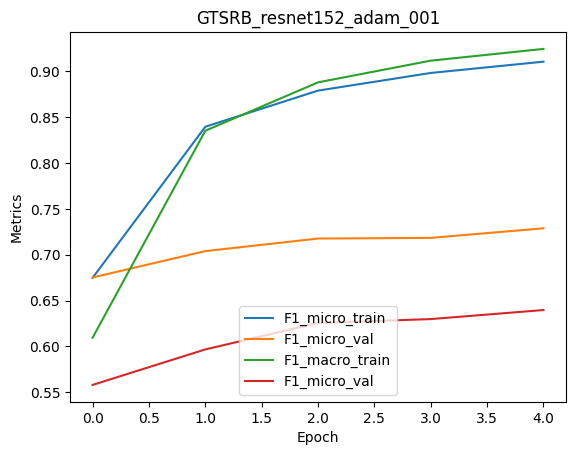

In [621]:
%matplotlib inline
fig, ax = plt.subplots()
ax.plot(train_f1_micros, label='F1_micro_train')
ax.plot(val_f1_micros, label='F1_micro_val')
ax.plot(train_f1_macros, label='F1_macro_train')
ax.plot(val_f1_macros, label='F1_micro_val')
ax.set_title(model_name)
ax.set(xlabel='Epoch', ylabel='Metrics')
ax.legend()
plt.show()